# Niveles de agua del Lago Cocibolca basado en altimetria satelital

1/25,23,18/2021

- [IPAD pagina web, Lago Cocibolca](https://ipad.fas.usda.gov/cropexplorer/global_reservoir/gr_regional_chart.aspx?regionid=ca&reservoir_name=Nicaragua)
- [IPAD archivo KML con puntos del "track" del sensor altimetrico](https://ipad.fas.usda.gov/rssiws/ggeoxml/351_Nicaragua.kml)
- [https://appliedsciences.nasa.gov/join-mission/training/english/mapping-and-monitoring-lakes-and-reservoirs-satellite-observations](https://appliedsciences.nasa.gov/join-mission/training/english/mapping-and-monitoring-lakes-and-reservoirs-satellite-observations) 
- [https://appliedsciences.nasa.gov/our-impact/news/africa-flores-breakthrough-scientist](https://appliedsciences.nasa.gov/our-impact/news/africa-flores-breakthrough-scientist)
- https://www.google.com/search?q=altimetria+satelite+radar
- https://en.wikipedia.org/wiki/Sentinel-6_Michael_Freilich
- https://www.aviso.altimetry.fr/es/casero.html
- *From Charon Birkett*
  - 1/25: The USDA G-REALM site is back up and running
  - 1/22: Yes, all product creation has stopped while the system transfers to a new server, we have also been short of staff to post a news bulletin. We hope the service will resume by Feb 1st. There is no issue with the Jason-3 data. In fact the follow-on mission to Jason-3 (called Sentinel-6) was launched successfully in November 2020. Jason-3 will stop monitoring at the end of 2021.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import folium
%matplotlib inline

import warnings
warnings.simplefilter('ignore') # filter some warning messages

In [2]:
matplotlib.style.use('ggplot')

## Acceder e ingerir los datos de niveles de agua

In [3]:
fname = 'lake0351.10d.2.smooth.txt'

In [4]:
url = f"https://ipad.fas.usda.gov/lakes/images/{fname}"
url

'https://ipad.fas.usda.gov/lakes/images/lake0351.10d.2.smooth.txt'

- Try using `infer_datetime_format` or `date_parser`
- Cambiar los nombres de las columnas a espanol

In [5]:
df0 = pd.read_csv(url, names=['fecha', 'hora', 'minuto', 'nivel', 'nivel_egm2008'],
                  skiprows=12, index_col=False, sep='\s+')

In [6]:
len(df0)

1105

In [7]:
df0.tail()

,fecha,hora,minuto,nivel,nivel_egm2008
1100,99999999,99,99,999.99,9999.99
1101,20201127,3,26,0.68,32.71
1102,99999999,99,99,999.99,9999.99
1103,20201216,23,23,0.82,32.85
1104,20201226,21,22,0.73,32.76


In [8]:
df0.dtypes

fecha              int64
hora               int64
minuto             int64
nivel            float64
nivel_egm2008    float64
dtype: object

## Pre-procesar y suplementar los datos ingeridos

In [9]:
df = df0[(df0['fecha'] != 99999999) & (df0['nivel'] < 999)].copy()
len(df)

1072

In [10]:
# Time *must* be zero-padded in conversion from integer to string
df.insert(1, 'FechaTiempo', 
          pd.to_datetime(
              df['fecha'].map(str) 
              + df['hora'].map(lambda nbr: "{0:02d}".format(nbr))
              + df['minuto'].map(lambda nbr: "{0:02d}".format(nbr)),
              format='%Y%m%d%H%M')
         )

In [11]:
df.drop(['fecha', 'hora', 'minuto'], axis=1, inplace=True)

In [12]:
df.tail(15)

,FechaTiempo,nivel,nivel_egm2008
1087,2020-07-11 07:47:00,-0.26,31.77
1088,2020-07-21 05:46:00,-0.21,31.82
1089,2020-07-31 03:44:00,-0.18,31.85
1090,2020-08-10 01:43:00,-0.10,31.93
1091,2020-08-19 23:41:00,-0.02,32.01
1092,2020-08-29 21:40:00,0.07,32.10
1093,2020-09-08 19:38:00,0.15,32.18
1094,2020-09-18 17:37:00,0.24,32.27
1095,2020-09-28 15:35:00,0.29,32.32
1096,2020-10-08 13:34:00,0.37,32.40


**Hay que averiguar porque los datos terminan en Octubre.**

In [13]:
df['año'] = df.FechaTiempo.dt.year
df['mes'] = df.FechaTiempo.dt.month
df['dia'] = df.FechaTiempo.dt.day
df['dda'] = df.FechaTiempo.dt.dayofyear

## Explorar patrones temporales

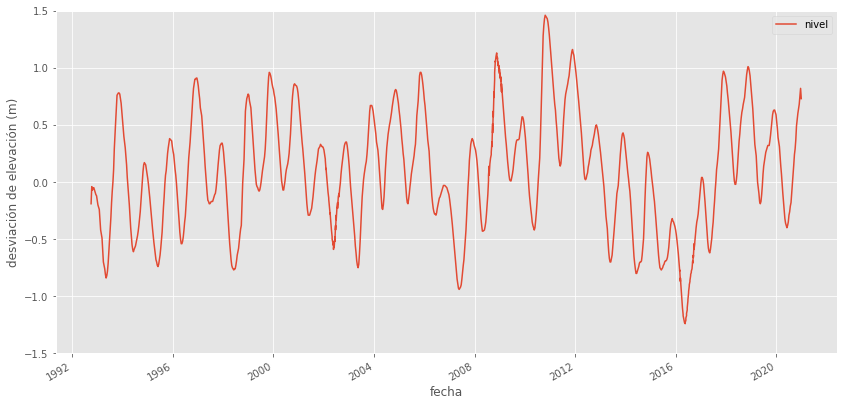

In [14]:
df.plot(x='FechaTiempo', y='nivel', ylim=(-1.5, 1.5), figsize=(14, 7))
plt.ylabel('desviación de elevación (m)')
plt.xlabel('fecha');

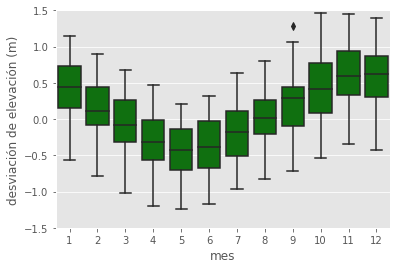

In [15]:
sns.boxplot(data=df, x='mes', y='nivel', color='g');
plt.ylim(-1.5, 1.5)
plt.xlabel('mes')
plt.ylabel('desviación de elevación (m)'); 

In [16]:
# df.plot.scatter(x="dda", y="nivel", c="año");

x-axis date formatting. Probably better to use matplotlib date formatting. See https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/

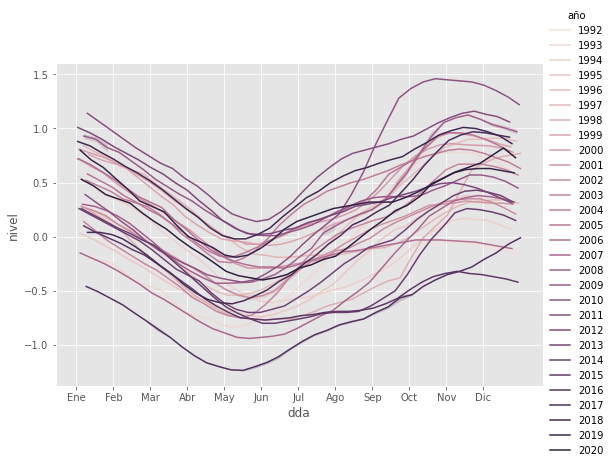

In [17]:
# markers=True, dashes=False: these have no effect
palette = sns.cubehelix_palette(light=.9, n_colors=29)

sns.relplot(data=df, x="dda", y="nivel", hue="año", kind='line', palette=palette,
            height=5, aspect=1.5)
# Change x axis labelling to show months rather than just dda integers
# 0,365 for start of month; 15,380 for middle of month
plt.xticks(np.linspace(0,365,13)[:-1], 
           ('Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic')
          );

In [18]:
dfg = df.groupby('año')

In [19]:
dfheightrange = dfg.nivel.max() - dfg.nivel.min()

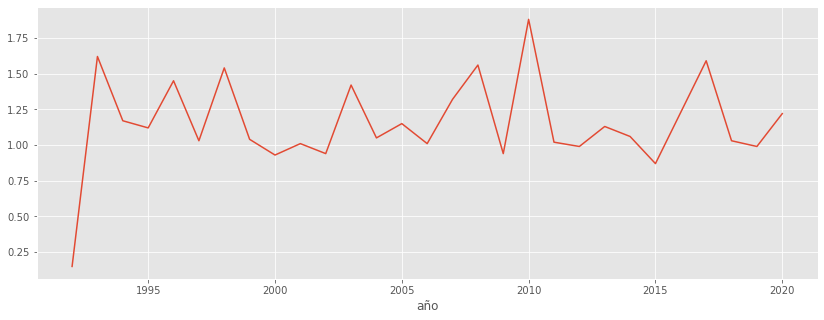

In [20]:
dfheightrange.plot(figsize=(14,5));

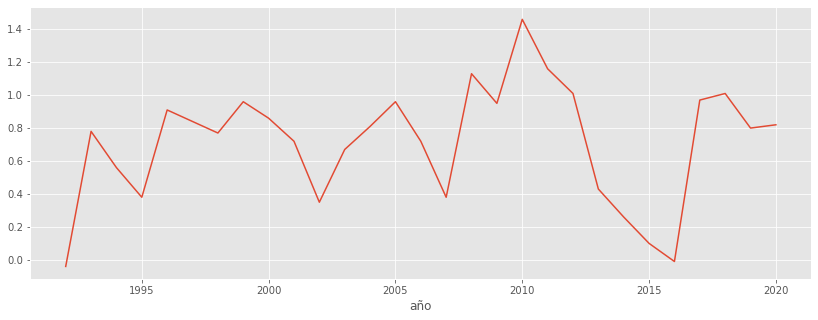

In [21]:
dfg.nivel.max().plot(figsize=(14,5));

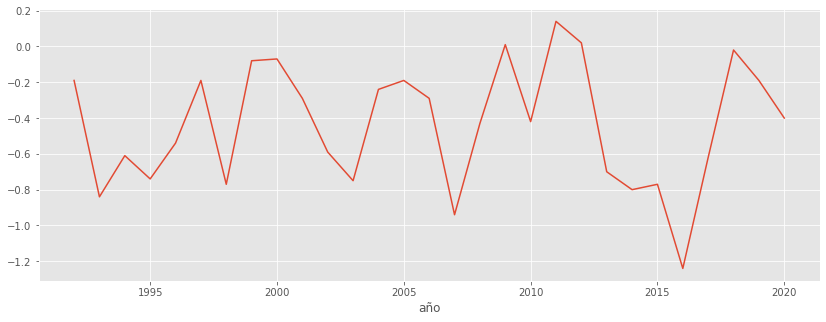

In [22]:
dfg.nivel.min().plot(figsize=(14,5));

## Leer el paso satelital y visualizar en un mapa

In [23]:
kmlurl = "https://ipad.fas.usda.gov/rssiws/ggeoxml/351_Nicaragua.kml"

In [24]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

See this good reference for reading KMLs and their complexities: https://gis.stackexchange.com/questions/328525/geopandas-read-file-only-reading-first-part-of-kml

In [25]:
gdf = gpd.read_file(kmlurl, driver='KML')

In [26]:
len(gdf)

190

In [27]:
gdf.tail()

,Name,Description,geometry
185,,,POINT (-85.63035 0.00000)
186,,,POINT (-85.62943 0.00000)
187,,,POINT (-85.62851 0.00000)
188,,,POINT (-85.62759 0.00000)
189,Topex/Jason Pass,,"LINESTRING (-85.80074 11.56268, -85.79982 11.5..."


In [28]:
gdf.geometry.type.value_counts()

Point         189
LineString      1
dtype: int64

In [29]:
# usando folium.Figure para controlar el taman-o sin introducir "padding"
fig = folium.Figure(width='60%')
mapa = folium.Map(tiles='StamenTerrain').add_to(fig)

folium.GeoJson(
    gdf[gdf.Name == 'Topex/Jason Pass'].geometry,
    tooltip="Paso satelital Topex/Jason"
).add_to(mapa)

# Set the map extent (bounds) to the extent of the bounding box
mapa.fit_bounds(mapa.get_bounds())

In [30]:
mapa